1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [115]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import random

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [130]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [131]:
# Число деревьев в ансамбле
n_trees = 20

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
start_depth = 1
end_depth = 10

# Шаг
eta = 0.1

trees_depth = [] 
train_errors_depth = [] 
test_errors_depth = [] 
for n_depth in range(start_depth, end_depth + 1):
    trees, train_errors, test_errors = gb_fit(n_trees, n_depth, X_train, X_test, y_train, y_test, coefs, eta)
    trees_depth.append(trees)
    train_errors_depth.append(train_errors)
    test_errors_depth.append(test_errors)
    

Построим графики зависимости ошибки на обучающей и тестовой выборках от количества деревьев в ансамбле.

In [28]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [132]:
def get_error_plot(n_trees, train_errors_depth, test_errors_depth, vn_depth):
    plt.xlabel(f'Number of trees (depth = {vn_depth})')
    plt.ylabel('MSE')
    plt.xlim(1, n_trees)
    plt.plot(list(range(1, n_trees+1)), train_errors_depth[vn_depth-start_depth], label='train error')
    plt.plot(list(range(1, n_trees+1)), test_errors_depth[vn_depth-start_depth], label='test error')
    plt.legend(loc='upper right')
    plt.show()

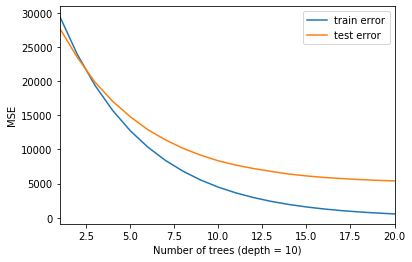

In [148]:
get_error_plot(n_trees, train_errors_depth, test_errors_depth, 10)

In [134]:
def get_error_plot_by_depth(vn_trees, train_errors_depth, test_errors_depth):
    plt.xlabel(f'Depth (number of tree = {vn_trees})')
    plt.ylabel('MSE')
    plt.xlim(start_depth, end_depth)
    plt.plot(list(range(start_depth, end_depth+1)), list(zip(*train_errors_depth))[vn_trees-1], label='train error')
    plt.plot(list(range(start_depth, end_depth+1)), list(zip(*test_errors_depth))[vn_trees-1], label='test error')
    plt.legend(loc='upper right')
    plt.show()

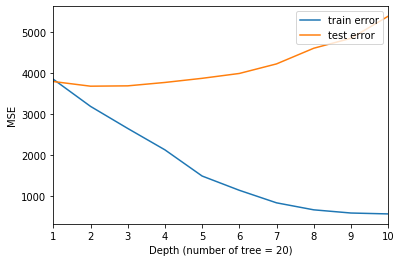

In [135]:
get_error_plot_by_depth(20, train_errors_depth, test_errors_depth)

При увеличении количества деревьев качество улучшается, а при увеличении глубины деревьев наступает переобучение, так как ошибка на тренировочной выборке падает, а на тестовой растет

2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [161]:
random.seed(42)

def sgb_fit(n_trees, max_n_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    n_sample = len(y_train)//2 + 1
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_n_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            # алгоритмы начиная со второго обучаем на сдвиг
            sample_index = [random.randint(0, n_sample) for _ in range(n_sample)]
            tree.fit(X_train[sample_index, :], bias(y_train[sample_index], target[sample_index]))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [174]:
# Число деревьев в ансамбле
n_trees = 20

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
start_depth = 1
end_depth = 10

# Шаг
eta = 0.1

sgb_trees_depth = [] 
sgb_train_errors_depth = [] 
sgb_test_errors_depth = [] 
for n_depth in range(start_depth, end_depth + 1):
    sgb_trees, sgb_train_errors, sgb_test_errors = sgb_fit(n_trees, n_depth, X_train, X_test, y_train, y_test, coefs, eta)
    sgb_trees_depth.append(sgb_trees)
    sgb_train_errors_depth.append(sgb_train_errors)
    sgb_test_errors_depth.append(sgb_test_errors)

In [175]:
def get_error_plot_sgb(n_trees, test_errors_depth, sgb_test_errors_depth, vn_depth):
    plt.xlabel(f'Number of trees (depth = {vn_depth})')
    plt.ylabel('MSE')
    plt.xlim(1, n_trees)
    plt.plot(list(range(1, n_trees+1)), test_errors_depth[vn_depth-start_depth], label='test error')
    plt.plot(list(range(1, n_trees+1)), sgb_test_errors_depth[vn_depth-start_depth], label='sgb test error')
    plt.legend(loc='upper right')
    plt.show()

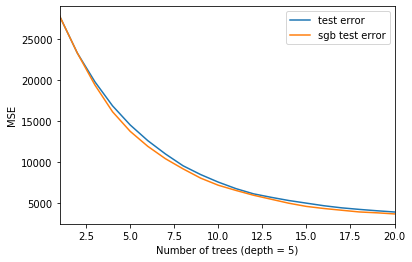

In [176]:
get_error_plot_sgb(n_trees, test_errors_depth, sgb_test_errors_depth, 5)

In [177]:
def get_error_plot_by_depth_sgb(vn_trees, test_errors_depth, sgb_test_errors_depth):
    plt.xlabel(f'Depth (number of tree = {vn_trees})')
    plt.ylabel('MSE')
    plt.xlim(start_depth, end_depth)
    plt.plot(list(range(start_depth, end_depth+1)), list(zip(*test_errors_depth))[vn_trees-1], label='test error')
    plt.plot(list(range(start_depth, end_depth+1)), list(zip(*sgb_test_errors_depth))[vn_trees-1], label='sgb test error')
    plt.legend(loc='upper right')
    plt.show()

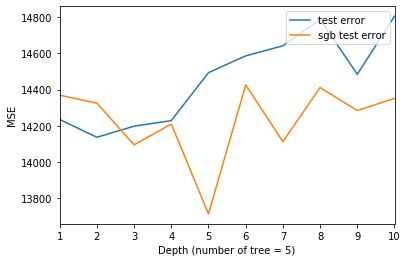

In [178]:
get_error_plot_by_depth_sgb(5, test_errors_depth, sgb_test_errors_depth)